### Louvein community detection experiments
Here we collect all exeriments with Louvein algorithm  
1. Run 20 times on all data network with 
2. Czech sources discovery run
3. Big feasts only
4. United provenances?

In [1]:
# Imports
import numpy as np
import pandas as pd

import networkx as nx
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, jaccard_score

import matplotlib.pyplot as plt
from itertools import combinations
from random import sample, seed
from collections import Counter

import lzma
import pickle

In [2]:
# Read data
responsories_all = pd.read_csv('../data/all-ci-responsories.csv', usecols=['cantus_id', 'incipit', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})
antiphons_all = pd.read_csv('../data/all-ci-antiphons.csv', usecols=['cantus_id', 'incipit', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})

sources = pd.read_csv('../data/sources-with-provenance-ids-and-two-centuries.csv', usecols=['provenance_id', 'drupal_path', 'siglum', 'cursus', 'num_century'])
feasts = pd.read_csv('../data/feast.csv', usecols=['id', 'name'])

chants = pd.concat([responsories_all, antiphons_all])

Common code

In [3]:
# Set compare metric
def Jaccard_metrics(a : list, b : list):
    '''
    Function returns value of Jaccard metrics applied on two sets
    '''
    if len(set(a).union(set(b))) != 0:
        return (len(set(a).intersection(set(b))) / len(set(a).union(set(b))))
    else:
        return 0

In [4]:
# Source translate to int for smooth labels array indexing 
from collections import OrderedDict

source_dict = OrderedDict()
i = 0
for id in sources['drupal_path']:
    source_dict[id] = i
    i += 1

In [5]:
def get_columns(metric, used_sources, source_chants_dict):
    
    len_s = len(used_sources)
    s1_column = [j for i in [len_s * [s] for s in used_sources] for j in i]
    s2_column = len_s * used_sources

    shared_column = []
    for i in range(len(s1_column)):
        s1_chants = source_chants_dict[s1_column[i]]
        s2_chants = source_chants_dict[s2_column[i]]
        shared_column.append(metric(s1_chants, s2_chants))
    
    return s1_column, s2_column, shared_column, used_sources

In [6]:
def get_graph(used_sources, source_chants_dict):
    s1_column, s2_column, shared_column, used_sources = get_columns(Jaccard_metrics, used_sources, source_chants_dict)
    nodes = used_sources
    edges = [(i, j, {'weight': round(w, 2) }) for i, j, w in zip(s1_column, s2_column, shared_column) if i != j and w != 0 and (i in used_sources and j in used_sources)]
    
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    
    return graph

In [7]:
def transform_to_labels(variant, used_dict):
    labels = np.zeros(len(used_dict.keys()))
    j = 0
    for community in variant:
        for vertex in community:
            labels[used_dict[vertex]] = j
        j += 1
    return labels

In [8]:
def count_jaccard(community_variants, used_dict):
    jaccard = []
    all_variants_pairs = [(a, b) for idx, a in enumerate(community_variants) for b in community_variants[idx + 1:]]
    for pair in all_variants_pairs:
        friends_matrix = np.zeros([len(used_dict), len(used_dict)])
        for com_ver in pair:
            for com in com_ver:
                com = sorted(list(com))
                for s_pair in combinations(com, 2):
                    friends_matrix[used_dict[s_pair[0]], used_dict[s_pair[1]]] += 1
        unique, counts = np.unique(friends_matrix.flatten(), return_counts=True)
        try:
            twos = dict(zip(unique, counts))[2]
            sig_level = twos / np.count_nonzero(friends_matrix)
        except:
            sig_level = 0.0
        jaccard.append(sig_level)
    
    return (round(np.mean(jaccard), 3)) 

In [9]:
def count_rand(community_variants_labels):
    rand = []
    all_variants_pairs = [(a, b) for idx, a in enumerate(community_variants_labels) for b in community_variants_labels[idx + 1:]]
    for pair in all_variants_pairs:
        rand.append(adjusted_rand_score(pair[0], pair[1]))
    
    return (round(np.mean(rand), 3))

In [10]:
def count_mutual(community_variants_labels):
    mutual = []
    all_variants_pairs = [(a, b) for idx, a in enumerate(community_variants_labels) for b in community_variants_labels[idx + 1:]]
    for pair in all_variants_pairs:
        mutual.append(adjusted_mutual_info_score(pair[0], pair[1]))
        
    return (round(np.mean(mutual), 3))

In [11]:
# Construct needed data structures to construct networks from all data
drupals = sources['drupal_path'].tolist()
source_chants_dict = {}
used_sources = []

for source_id in drupals:
    chants_of_source = chants[chants['source_id'] == source_id]['cantus_id'].tolist()
    
    if chants_of_source != []:
        used_sources.append(source_id)
        try:
            source_chants_dict[source_id] += chants_of_source
        except:
            source_chants_dict[source_id] = chants_of_source

used_sources = list(set(used_sources))

### Parameter search

We have basicly only one available parameter to be set:  
<b> resolution</b>  - default is 1  
(If resolution is less than 1, the algorithm favors larger communities, if greater than 1 favors smaller communities)


In [18]:
random_states_res = [i for i in range(1, 151)]
resolution_opt = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]

In [19]:
all_graph = get_graph(used_sources, source_chants_dict)

In [27]:
res_dict = {}
num_of_runs_res = 50
for res in resolution_opt:
    print(res)
    community_variants_res = []
    community_variants_labels_res = []
    num_of_clusters_res = []
    for i in range(num_of_runs_res):
        variant = nx.community.louvain_communities(all_graph, weight='weight', resolution=res, seed=random_states_res[i])
        community_variants_res.append(variant)
        community_variants_labels_res.append(transform_to_labels(variant, source_dict))
        num_of_clusters_res.append(len(variant))
    res_dict[res] = (count_jaccard(community_variants_res, source_dict), count_rand(community_variants_labels_res), count_mutual(community_variants_labels_res), np.mean(num_of_clusters_res))

0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8


In [28]:
with lzma.open("louvein_res.txt", "wb") as model_file:
    pickle.dump(res_dict, model_file)

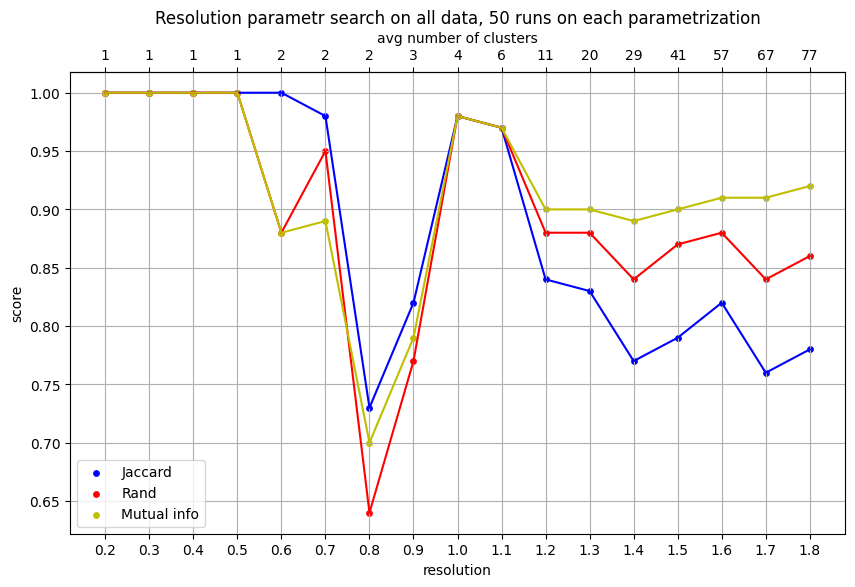

In [30]:
# Plot results of resolution parameter search
colors = ['b', 'r', 'y']
labels = ['Jaccard', 'Rand', 'Mutual info']
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
for i in range(3):
    ax1.scatter(x=resolution_opt, y=[x[i] for x in res_dict.values()], marker='o', c=colors[i], s=15, label=labels[i])
    ax1.plot(resolution_opt, [x[i] for x in res_dict.values()], c=colors[i])

ax2 = ax1.secondary_xaxis('top')
avg_clusters = [round(x[3]) for x in res_dict.values()]
ax2.set_xlabel("avg number of clusters")
ax2.set_xticks(resolution_opt)
ax2.set_xticklabels(avg_clusters)

plt.title("Resolution parametr search on all data, 50 runs on each parametrization")
plt.xticks(resolution_opt)
plt.xlabel("resolution")
plt.ylabel("score")
plt.legend(loc='lower left') #bbox_to_anchor=(1.05, 1.0)
plt.grid()
plt.show()

In [24]:
#Resolution and seed generating stable four communnities
random_states_r = [i for i in range(1, 51)]
community_variants_res = []
community_variants_labels_res = []
num_of_clusters_res = []
for i in range(20):
    variant = nx.community.louvain_communities(all_graph, weight='weight', resolution=1.0, seed=random_states_r[i])
    community_variants_res.append(variant)
    community_variants_labels_res.append(transform_to_labels(variant, source_dict))
    num_of_clusters_res.append(len(variant))

In [25]:
print((count_jaccard(community_variants_res, source_dict), count_rand(community_variants_labels_res), count_mutual(community_variants_labels_res), np.mean(num_of_clusters_res)))

(0.97, 0.98, 0.98, 4.0)


In [102]:
for com in community_variants_res[0]:
    #print(len(com), com)
    print(len(com), sorted([sources[sources['drupal_path'] == s]['siglum'].tolist()[0] for s in com]))

93 [' E-Bbc M 662', 'A-Gu 30', 'A-KN 1012', 'A-KN 1018', 'A-KN 589', 'A-Wda C-10', 'A-Wda D-4', 'Antifonario Antifonario de la Santa Cruz de Serós', 'B-Gu Hs BKT.006', 'CDN-Mlr MS Medieval 0073', 'CDN-Mlr MS Medieval 0234', 'CH-SGs 391', 'CZ-Bu R 387', 'CZ-Pn XII A 21', 'CZ-Pu VI E 13', 'CZ-Pu VI G 3a', 'CZ-Pu XII C 3', 'CZ-Pu XII E 15b', 'CZ-Pu XII E 15c', 'CZ-Pu XIII C 1a', 'CZ-Pu XIII C 4', 'CZ-Pu XIV C 20', 'CZ-Pu XIV G 46', 'CZ-Pu XXIII D 156 ', 'CZ-R R 17', 'D-BAs Msc.Lit.25', 'D-FUl Aa 55', 'D-MZb C', 'D-MZb D', 'D-MZb E', 'D-Mbs Clm 4304', 'D-Mbs Clm 4305', 'D-Mbs Clm 4306', 'D-W 28 Helmst.', 'DK-Kk 3449 8o [03] III', 'DK-Kk 3449 8o [06] VI', 'DK-Kk 3449 8o [07] VII', 'DK-Kk 3449 8o [08] VIII', 'DK-Kk 3449 8o [09] IX', 'DK-Kk 3449 8o [10] X', 'DK-Kk 3449 8o [11] XI', 'DK-Kk 3449 8o [12] XII', 'DK-Kk 3449 8o [13] XIII', 'DK-Kk 3449 8o [14] XIV', 'DK-Kk 3449 8o [16] XVI', 'DK-Kk 3449 8o [17] XVII', 'E-Bbc M 1327', 'E-Bbc M 3701', 'E-E E-E, L. III. 3.', 'E-E E-E, L. III. 4.', 'E-H

### All data network

Construct network from all available data with resolution = 1 and 1.1 and count score of results

In [12]:
num_of_runs_all = 50
random_states_all = [x for x in range(1, 1001)]
all_res = [1.0, 1.1]

In [13]:
community_variants_all = []
community_variants_labels_all = []
num_of_clusters_all = []
for r in range(len(all_res)): 
    rndm_idx = 0
    community_variants_all.append([])
    community_variants_labels_all.append([])
    num_of_clusters_all.append([])
    for j in range(5):
        community_variants_all[r].append([])
        community_variants_labels_all[r].append([])
        num_of_clusters_all[r].append([])
        all_graph = get_graph(used_sources, source_chants_dict)
        for i in range(num_of_runs_all):
            variant = nx.community.louvain_communities(all_graph, weight='weight', resolution=all_res[r], seed=random_states_all[rndm_idx])
            community_variants_all[r][j].append(variant)
            num_of_clusters_all[r][j].append(len(variant))
            community_variants_labels_all[r][j].append(transform_to_labels(variant, source_dict))
            rndm_idx+=1
    
    print('Resolution:', all_res[r])
    print('Results of', num_of_runs_all, 'runs on all data network')
    print('Average number of clusters:', [np.mean(num_of_clusters_all[r][x]) for x in range(5)])
    print('Jaccard score:', [count_jaccard(community_variants_all[r][x], source_dict) for x in range(5)])
    print('Rand score:', [count_rand(community_variants_labels_all[r][x]) for x in range(5)])
    print('Mutual info score:', [count_mutual(community_variants_labels_all[r][x]) for x in range(5)])
    print()

Resolution: 1.0
Results of 50 runs on all data network
Average number of clusters: [4.0, 4.0, 4.0, 3.98, 4.0]
Jaccard score: [0.977, 0.987, 0.988, 0.982, 0.978]
Rand score: [0.981, 0.989, 0.99, 0.983, 0.982]
Mutual info score: [0.984, 0.99, 0.991, 0.987, 0.984]

Resolution: 1.1
Results of 50 runs on all data network
Average number of clusters: [6.18, 6.08, 6.32, 6.26, 6.2]
Jaccard score: [0.983, 0.972, 0.986, 0.979, 0.976]
Rand score: [0.988, 0.98, 0.99, 0.985, 0.983]
Mutual info score: [0.983, 0.972, 0.985, 0.977, 0.976]



In [14]:
all_dict = {'cluster' : num_of_clusters_all, 'var' : community_variants_all, 'var_labels' : community_variants_labels_all}
with lzma.open("louvein_all_dict.txt", "wb") as model_file:
    pickle.dump(all_dict, model_file)

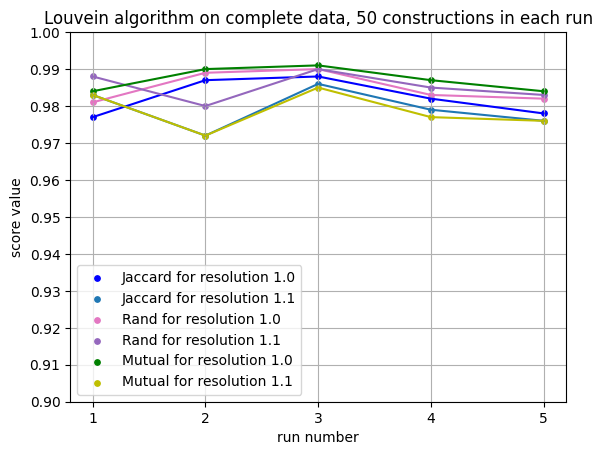

In [15]:
colors = ['b', 'tab:orange', 'tab:pink', 'tab:blue', 'g', 'tab:purple', 'c', 'tab:brown', 'r', 'tab:gray', 'y', 'm']
metrics = ['Jaccard', 'Rand', 'Mutual']
fig = plt.figure()
ax1 = fig.add_subplot(111)

j = 0
for i in range(len(all_res)):
    ax1.scatter(x=[1, 2, 3, 4, 5], y=[count_jaccard(community_variants_all[i][x], source_dict) for x in range(5)], s=15, c=colors[j], marker="o", label="Jaccard for resolution "+str(all_res[i]))
    ax1.plot([1, 2, 3, 4, 5], [count_jaccard(community_variants_all[i][x], source_dict) for x in range(5)], c=colors[j])
    j+=3

j = 2
for i in range(len(all_res)):
    ax1.scatter(x=[1, 2, 3, 4, 5], y=[count_rand(community_variants_labels_all[i][x]) for x in range(5)], s=15, c=colors[j], marker="o", label="Rand for resolution "+str(all_res[i]))
    ax1.plot([1, 2, 3, 4, 5], [count_rand(community_variants_labels_all[i][x]) for x in range(5)], c=colors[j])
    j+=3

j = 4
for i in range(len(all_res)):
    ax1.scatter(x=[1, 2, 3, 4, 5], y=[count_mutual(community_variants_labels_all[i][x]) for x in range(5)], s=15, c=colors[j], marker="o", label="Mutual for resolution "+str(all_res[i]))
    ax1.plot([1, 2, 3, 4, 5], [count_mutual(community_variants_labels_all[i][x]) for x in range(5)], c=colors[j])
    j+=6

plt.xlabel("run number")
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel("score value")
plt.yticks([0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
plt.title("Louvein algorithm on complete data, 50 constructions in each run")
plt.grid()
plt.legend(loc='lower left')
plt.show()

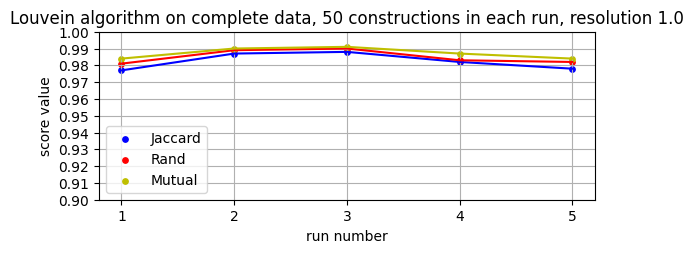

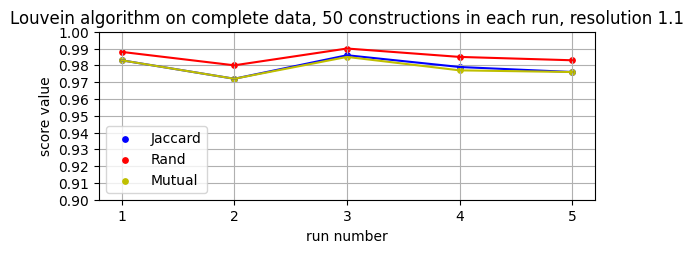

In [16]:
plt.subplot(2, 1, 1)
plt.scatter(x=[1, 2, 3, 4, 5], y=[count_jaccard(community_variants_all[0][x], source_dict) for x in range(5)], s=15, c='b', marker="o", label="Jaccard")
plt.plot([1, 2, 3, 4, 5], [count_jaccard(community_variants_all[0][x], source_dict) for x in range(5)], c='b')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_rand(community_variants_labels_all[0][x]) for x in range(5)], s=15, c='r', marker="o", label="Rand")
plt.plot([1, 2, 3, 4, 5], [count_rand(community_variants_labels_all[0][x]) for x in range(5)], c='r')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_mutual(community_variants_labels_all[0][x]) for x in range(5)], s=15, c='y', marker="o", label="Mutual")
plt.plot([1, 2, 3, 4, 5], [count_mutual(community_variants_labels_all[0][x]) for x in range(5)], c='y')

plt.title('Louvein algorithm on complete data, 50 constructions in each run, resolution 1.0')
plt.xlabel("run number")
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel("score value")
plt.yticks([0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
plt.grid()
plt.legend(loc='lower left')
plt.show()


plt.subplot(2, 1, 2)
plt.scatter(x=[1, 2, 3, 4, 5], y=[count_jaccard(community_variants_all[1][x], source_dict) for x in range(5)], s=15, c='b', marker="o", label="Jaccard")
plt.plot([1, 2, 3, 4, 5], [count_jaccard(community_variants_all[1][x], source_dict) for x in range(5)], c='b')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_rand(community_variants_labels_all[1][x]) for x in range(5)], s=15, c='r', marker="o", label="Rand")
plt.plot([1, 2, 3, 4, 5], [count_rand(community_variants_labels_all[1][x]) for x in range(5)], c='r')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_mutual(community_variants_labels_all[1][x]) for x in range(5)], s=15, c='y', marker="o", label="Mutual")
plt.plot([1, 2, 3, 4, 5], [count_mutual(community_variants_labels_all[1][x]) for x in range(5)], c='y')

plt.title('Louvein algorithm on complete data, 50 constructions in each run, resolution 1.1')
plt.xlabel("run number")
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel("score value")
plt.yticks([0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
plt.grid()
plt.legend(loc='lower left')
plt.show()

### Czech sources behaviour
Construct network only from data for feasts that are in all "our" six sources and obsreve on what resolution they separate and how

In [67]:
six_czech_sources = {"http://cantusbohemiae.cz/source/33177" : "CZ-Pn XII A 24", 
                      "http://cantusbohemiae.cz/source/4478" : "CZ-Pu Pu XIV A 19", 
                      "http://cantusbohemiae.cz/source/28509" : "CZ-Pn XV A 10",
                      "http://cantusdatabase.org/source/123730" : "CZ-Pu XIV B 13", 
                      "http://cantusdatabase.org/source/123727" : "CZ-Pu VI.E.4c", 
                      "http://cantusbohemiae.cz/source/28488" : "CZ-Pu VI G 11"}

In [68]:
cathedral_used_feats = []
for sI in list(six_czech_sources.keys())[:3]:
    print(sI, len(chants[chants['source_id'] == sI]))
    cathedral_used_feats += set(chants[chants['source_id'] == sI]['feast_id'].dropna().tolist())

# Cathedral field
freqC = Counter(cathedral_used_feats)
three_cathedral_feasts = []
for key in freqC.keys():
    if freqC[key] >=3:
        three_cathedral_feasts.append(key)

# George monastery
monastery_used_feats = []
for sI in list(six_czech_sources.keys())[3:]:
    print(sI, len(chants[chants['source_id'] == sI]))
    monastery_used_feats += set(chants[chants['source_id'] == sI]['feast_id'].dropna().tolist())

freqM = Counter(monastery_used_feats)
three_monastery_feasts = []
for key in freqM.keys():
    if freqM[key] >= 3:
        three_monastery_feasts.append(key)

complete_feasts = set(three_cathedral_feasts).intersection(set(three_monastery_feasts))
print("Number of feast in all six sources:", len(complete_feasts))

http://cantusbohemiae.cz/source/33177 582
http://cantusbohemiae.cz/source/4478 988
http://cantusbohemiae.cz/source/28509 1741
http://cantusdatabase.org/source/123730 1403
http://cantusdatabase.org/source/123727 2327
http://cantusbohemiae.cz/source/28488 2616
Number of feast in all six sources: 37


In [69]:
# Complete needed data
feast_source_chants_dict = {}
feast_used_cantus_ids = []
feast_used_sources = []
for source_id in sources['drupal_path'].tolist():
    filt_source = chants[chants['source_id'] == source_id]
    source_feast_chants = (filt_source[filt_source['feast_id'].isin(complete_feasts)]['cantus_id']).tolist()
    if source_feast_chants != []:
        feast_used_cantus_ids += source_feast_chants 
        feast_source_chants_dict[source_id] = source_feast_chants
        feast_used_sources.append(source_id)

print("Used sources:", len(feast_used_sources))
print('Number of CIDs used in our sources:', len(set(feast_used_cantus_ids)))

Used sources: 153
Number of CIDs used in our sources: 1224


In [70]:
czech_dict = {}
num_of_clusters_feast = []
all_graph = get_graph(feast_used_sources, feast_source_chants_dict)
for res in resolution_opt:
    print(res)
    community_variants_feast = []
    community_variants_labels_feast = []
    num_of_clusters_res = []
    variant = nx.community.louvain_communities(all_graph, weight='weight', resolution=res, seed=42)
    num_of_clusters_feast.append(len(variant))
    czech_dict[res] = variant

0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8


In [71]:
for res in resolution_opt:
    print(res, ':')
    for com in czech_dict[res]:
        print(len(com), sorted([sources[sources['drupal_path'] == s]['siglum'].tolist()[0] for s in com]))
    print()

0.2 :
150 [' E-Bbc M 662', ' rps 12720 V', '1', 'A-Gu 29', 'A-KN 1010', 'A-KN 1011', 'A-KN 1013', 'A-KN 1015', 'A-KN 1017', 'A-KR VI/258', 'A-LIs 290', 'A-SF XI 480', 'A-VOR 287', 'A-Wda C-11', 'A-Wda D-4', 'A-Wn 1799**', 'A-Wn 1890', 'AUS-Sfl Add. Ms. 413', 'B-Br Ms IV/473', 'B-TO olv 63', 'B-TO olv 64', 'CDN-Hsmu M2149.L4', 'CDN-Mlr MS Medieval 0073', 'CDN-Mlr MS Medieval 0234', 'CH-E 611', 'CH-Fco Ms. 2', 'CH-SGs 388', 'CH-SGs 390', 'CZ-Pn XV A 10', 'CZ-Pst DE I 7', 'CZ-Pu Pu XIV A 19', 'CZ-Pu VI G 11', 'CZ-Pu VI.E.4c', 'CZ-Pu XIV B 13', 'Cz-Pn XII A 24', 'D-AAm G 20', 'D-B Mus. 40047', 'D-BAs Msc.Lit.25', 'D-KA Aug. LX', 'D-KNd 1161', 'D-KNd 215', 'D-MZb A', 'D-Ma 12o Cmm 1', 'D-Mbs Clm 4303', 'D-Mbs Clm 4306', 'D-Sl HB.I.55', 'D-W 29 Helmst.', 'DK-Kk 3449 8o [01] I', 'DK-Kk 3449 8o [02] II', 'DK-Kk 3449 8o [04] IV', 'E-BAR Cj. 95', 'E-BAR, s.s.', 'E-Bbc E-Bbc, M 705', 'E-Bbc E-Bbc, Ms. 619', 'E-Bbc M 663', 'E-Bbc M 706', 'E-Bbc Ms. 2545', 'E-Gs ms. 45 (olim Sant Feliu, 20)', 'E-H 

##### Some possible interesting details
- first 5 all same and very inbalanced
- 1.1 seems (again) like ideal resolution parameter -> separates czech sources in meaningful way but also does not generate too many communities

In [72]:
print(count_jaccard(list(czech_dict.values())[:5], source_dict))
for com in czech_dict[0.2]:
    print(len(com), com)

1.0
150 {'http://cantusdatabase.org/source/123612', 'http://cantusdatabase.org/source/123639', 'http://cantus.sk/source/3192', 'http://musmed.eu/source/13502', 'http://musmed.eu/source/13399', 'http://cantus.ispan.pl/source/22868', 'http://cantusbohemiae.cz/source/33177', 'http://cantusdatabase.org/source/123649', 'http://cantusdatabase.org/source/123708', 'http://musicahispanica.eu/source/20226', 'http://cantusdatabase.org/source/123645', 'http://musicahispanica.eu/source/23205', 'http://musicahispanica.eu/source/20228', 'http://cantusdatabase.org/source/123605', 'http://cantusdatabase.org/source/123664', 'http://cantusdatabase.org/source/123707', 'http://cantusdatabase.org/source/123670', 'http://cantusdatabase.org/source/123614', 'http://cantusdatabase.org/source/123636', 'http://cantusdatabase.org/source/123661', 'http://musmed.eu/source/11602', 'http://cantusdatabase.org/source/123687', 'http://cantusdatabase.org/source/123730', 'http://cantusdatabase.org/source/123736', 'http://c

In [76]:
for com in  czech_dict[1.0]:
    print(len(com), sorted([sources[sources['drupal_path'] == s]['siglum'].tolist()[0] for s in com]))

65 ['A-KR VI/258', 'A-Wda C-11', 'A-Wda D-4', 'AUS-Sfl Add. Ms. 413', 'B-TO olv 63', 'B-TO olv 64', 'CH-Fco Ms. 2', 'Cz-Pn XII A 24', 'D-BAs Msc.Lit.25', 'D-MZb A', 'D-Ma 12o Cmm 1', 'D-Mbs Clm 4303', 'D-Mbs Clm 4306', 'DK-Kk 3449 8o [01] I', 'E-BAR, s.s.', 'E-Bbc E-Bbc, M 705', 'E-Bbc E-Bbc, Ms. 619', 'E-Bbc M 663', 'E-Bbc Ms. 2545', 'E-Gs ms. 45 (olim Sant Feliu, 20)', 'E-H Ms. 2', 'E-H, Ms. 7 (ant. 5)', 'E-SI ms. 9', 'E-Tc 44.2', 'F-AS 465 (CGM 893)', 'F-CA 38', 'F-CA Impr. XVI C 4', 'F-Col_part Mont-Renaud', 'F-Pn Lat. 1085', 'F-Pn Lat. 1090', 'F-Pn Lat. 1240', 'F-Pn Lat. 12584', 'F-Pn Lat. 15181', 'F-Pn Lat. 17296', 'F-Pn Lat. 17436', 'F-Pn Lat. 17991', 'F-Pn NAL 01236', 'F-Pn NAL 1535', 'F-TOm 149', 'F-VAL 114', 'GB-Lbl Add MS 30848', 'GB-WO F.160', 'GB-WO F.160 (Facs)', 'H-Bu lat. 118', 'HR-Hf Cod. C', 'I-Ac 694', 'I-Ad 5', 'I-BV V 19', 'I-CHV', 'I-Far', 'I-Fl Conv. sopp. 560', 'I-Lc 601', 'I-MZ 15/79', 'I-Nn vi.E.20', 'I-PCd cod. 65', 'I-VCd CLXX', 'Mar. F 408', 'P-BRs Ms. 032'

In [73]:
for com in  czech_dict[1.1]:
    print(len(com), sorted([sources[sources['drupal_path'] == s]['siglum'].tolist()[0] for s in com]))

6 ['CH-SGs 388', 'CH-SGs 390', 'D-B Mus. 40047', 'D-KNd 215', 'GB-Ob MS. Laud Misc. 284', 'NL-Uu 406 (3 J 7)']
10 ['CH-Fco Ms. 2', 'D-Ma 12o Cmm 1', 'D-Mbs Clm 4303', 'H-Bu lat. 118', 'I-Ac 693', 'I-Ac 694', 'I-Ad 5', 'I-Nn vi.E.20', 'I-PCd cod. 65', 'US-Cn 24']
3 ['GB-WO F.160', 'GB-WO F.160 (Facs)', 'I-VCd CLXX']
2 ['A-Wda C-11', 'I-CHV']
9 ['A-Gu 29', 'A-LIs 290', 'A-Wn 1890', 'CH-E 611', 'CZ-Pu VI G 11', 'CZ-Pu VI.E.4c', 'CZ-Pu XIV B 13', 'D-KA Aug. LX', 'D-Sl HB.I.55']
7 ['F-AI 44', 'F-Col_part Mont-Renaud', 'F-Pn Lat. 1085', 'F-Pn Lat. 17296', 'GB-Lbl Add MS 30848', 'GB-Lbl Add MS 30850', 'I-Far']
6 ['A-KN 1011', 'A-KN 1013', 'A-KN 1015', 'A-SF XI 480', 'D-AAm G 20', 'SI-Lna 18 (olim 17)']
8 [' rps 12720 V', 'A-Wn 1799**', 'CDN-Hsmu M2149.L4', 'D-KNd 1161', 'F-Pn NAL 1411', 'P-AR Res. Ms. 021', 'PL-WRu I F 401', 'Theol. Lat. Qu. 149']
22 ['A-KR VI/258', 'A-Wda D-4', 'AUS-Sfl Add. Ms. 413', 'D-BAs Msc.Lit.25', 'D-Mbs Clm 4306', 'DK-Kk 3449 8o [01] I', 'E-BAR, s.s.', 'E-Bbc E-Bbc, 

### Big feasts network

In [74]:
# Get 10 feasts with most data
biggest_feasts = chants['feast_id'].value_counts()[:10].keys()

for feast_id in biggest_feasts.tolist():
    print(feasts[feasts['id'] == feast_id]['name'].values[0])

Nativitas Domini
Purificatio Mariae
Epiphania
Assumptio Mariae
Comm. Apostolorum
Comm. plurimorum Martyrum
Omnium Sanctorum
Fer. 5 in Cena Dom.
Dom. in Palmis
Joannis Baptistae


In [78]:
# Construct documents structure for those feasts
source_chants_dict_big_f = {}
used_cantus_ids_f = []
for source_id in sources['drupal_path'].tolist():
    filt_source = chants['source_id'] == source_id
    source_chants = chants[filt_source]
    if (source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id']).tolist() != []:
        used_cantus_ids_f += (source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id']).tolist()
        source_chants_dict_big_f[source_id] = source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id'].tolist()

print('Number of cantus_ids used in our sources:', len(set(used_cantus_ids_f)))
print('Number of sources containing our biggest feasts:', len(source_chants_dict_big_f))

Number of cantus_ids used in our sources: 1701
Number of sources containing our biggest feasts: 226


In [79]:
big_feast_dict = OrderedDict()
i = 0
for id in source_chants_dict_big_f.keys():
    big_feast_dict[id] = i
    i += 1

In [80]:
community_variants_big_f = []
community_variants_labels_big_f = []
num_of_clusters_big_f = []
num_of_runs_big_f = 50
random_states_big_f = [i for i in range(1, num_of_runs_big_f+1)]
big_f_graph = get_graph(list(source_chants_dict_big_f.keys()), source_chants_dict_big_f)
for i in range(num_of_runs_big_f):
    variant = nx.community.louvain_communities(big_f_graph, weight='weight', resolution=1.1, seed=random_states_big_f[i])
    community_variants_big_f.append(variant)
    num_of_clusters_big_f.append(len(variant))
    community_variants_labels_big_f.append(transform_to_labels(variant, big_feast_dict))

In [81]:
print('Results of', num_of_runs_big_f, 'runs on 10 biggest feasts data network')
print('Average number of clusters:', np.mean(num_of_clusters_big_f))
print('Jaccard score:', count_jaccard(community_variants_big_f, big_feast_dict))
print('Rand score:', count_rand(community_variants_labels_big_f))
print('Mutual info score:', count_mutual(community_variants_labels_big_f))

Results of 50 runs on 10 biggest feasts data network
Average number of clusters: 7.08
Jaccard score: 0.97
Rand score: 0.98
Mutual info score: 0.98


### Provenance union

In [89]:
# Provenance union - consider also century and cursus
sources['provenance_id'] = sources['provenance_id'].fillna('unknown')
prov_source_dict = {}
prov_chant_dict = {}
i=0
for index, row in sources.iterrows():
        # new place bc of unknown some info
    if row['cursus'] == 'Unknown' or row['num_century'] == 'unknown' or row['provenance_id'] == 'unknown':
        prov_source_dict[row['provenance_id']+'_'+str(i)] = [row['drupal_path']]
        i+=1
    # we have such place without unknown positions
    elif row['provenance_id']+'_'+str(row['num_century'])+'_'+row['cursus'] in prov_source_dict.keys():
        prov_source_dict[row['provenance_id']+'_'+str(row['num_century'])+'_'+row['cursus']].append(row['drupal_path'])
    # new time-cursus-place without unknown positions
    else: 
        prov_source_dict[row['provenance_id']+'_'+row['num_century']+'_'+row['cursus']] = [row['drupal_path']]

for prov in prov_source_dict.keys():
    prov_chant_dict[prov] = []
    for source_id in prov_source_dict[prov]:
        filt_source = chants['source_id'] == source_id
        prov_chant_dict[prov] += (chants[filt_source]['cantus_id']).tolist()

print('number of reduced source points:',  len(prov_chant_dict), '(out of', len(sources), 'sources)')

number of reduced source points: 193 (out of 250 sources)


In [90]:
used_provenances = list(prov_chant_dict.keys())
provenance_dict = OrderedDict()
i = 0
for id in used_provenances:
    provenance_dict[id] = i
    i += 1

In [91]:
community_variants_prov = []
community_variants_labels_prov = []
num_of_clusters_prov = []
num_of_runs_prov = 50
random_states_prov = [i for i in range(1, num_of_runs_prov+1)]
provenance_graph = get_graph(list(prov_chant_dict.keys()), prov_chant_dict)
for i in range(num_of_runs_prov):
    variant = nx.community.louvain_communities(provenance_graph, weight='weight', resolution=1.1, seed=random_states_prov[i])
    community_variants_prov.append(variant)
    num_of_clusters_prov.append(len(variant))
    community_variants_labels_prov.append(transform_to_labels(variant, provenance_dict))

In [92]:
print('Results of', num_of_runs_prov, 'runs on provenance union data network')
print('Average number of clusters:', np.mean(num_of_clusters_prov))
print('Jaccard score:', count_jaccard(community_variants_prov, provenance_dict))
print('Rand score:', count_rand(community_variants_labels_prov))
print('Mutual info score:', count_mutual(community_variants_labels_prov))

Results of 50 runs on provenance union data network
Average number of clusters: 8.94
Jaccard score: 0.95
Rand score: 0.97
Mutual info score: 0.96
